In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pydrake.all import MathematicalProgram, Solve, SolverOptions, CommonSolverOption

In [107]:
def solve_prog(ad_mat, points, point_to_exclude):
    prog = MathematicalProgram()
    n = ad_mat.shape[0]
    prog = MathematicalProgram()
    v = prog.NewBinaryVariables(n)
    prog.AddLinearCost(-np.sum(v))
    lambdas = prog.NewContinuousVariables(1,2+1)
    gammas = prog.NewContinuousVariables(n)

    Points_mat = np.concatenate((points,np.ones((n,1))), axis =1)

    for i in range(0,n):
        for j in range(i+1,n):
            if ad_mat[i,j] == 0:
                prog.AddLinearConstraint(v[i] + v[j] <= 1)

    #for i in range(n):
    constraint1 = -Points_mat@lambdas[0,:]+gammas
    constraint2 = Points_mat[point_to_exclude, :]@lambdas[0,:]  #+ np.sum(gammas)
    for k in range(n):
        prog.AddLinearConstraint(constraint1[k] >=0)

    prog.AddLinearConstraint(constraint2>=1) #-v[point_to_exclude]
    
    for vi, gi in zip(v, gammas):
        prog.AddLinearConstraint(gi >= 6*(vi-1))

    for vi,gi in zip(v, gammas):
        prog.AddLinearConstraint(6*(1-vi)>= gi )


    solver_options = SolverOptions()
    solver_options.SetOption(CommonSolverOption.kPrintToConsole, 1)

    result = Solve(prog, solver_options=solver_options)
    return result.is_success(), result.GetSolution(v), result.GetSolution(lambdas), result.GetSolution(gammas)

def hyperplanepoints(l):
    l1, l2, l3  = l
    assert l1 !=0 or l2!=0
    dir = np.array([-l2 , l1])
    dir /= np.linalg.norm(dir)
    if l1 == 0:
        point_on_line = np.array([0, -l3/l2])
    elif l2 == 0:
        point_on_line = np.array([-l3/l1, 0])
    else:
        point_on_line = np.array([1, (-l3-l1)/l2])
    pts = np.array([ point_on_line + dir*l for l in np.linspace(-100,100, 100 )])
    return pts

success
binary assignment:  [0. 1. 1. 1. 0.]
lambda critical:  [-1. -1.  1.]
gamma critical:  [1. 0. 0. 0. 1.]


(-3, 3)

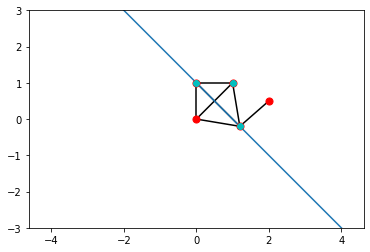

In [87]:
points = np.array([[0,0],
                   [1.2,-0.2],
                   [1,1],
                   [0,1],
                   [2,0.5]])

ad_mat = np.array([[0,1,1,1,0],
                   [1,0,1,1,1],
                   [1,1,0,1,0],
                   [1,1,1,0,0],
                   [0,1,0,0,0]])


        
fig = plt.figure()
plt.scatter(points[:,0], points[:,1], s= 50, c = 'r', zorder = 3)
for i in range(len(points)-1):
    for j in range(i+1, len(points)):
        if ad_mat[i,j]:
            x = [points[i,0], points[j,0]]
            y = [points[i,1], points[j,1]]
            plt.plot(x,y, c = 'k')

ax = plt.gca()
ax.axis('equal')

success, v, lambdas, gammas = solve_prog(ad_mat, points, 0)
pts_idx = np.nonzero(v)[0]
lambdas = lambdas.squeeze()
clique = np.array([points[i] for i in pts_idx])
plt.scatter(clique[:, 0], clique[:, 1], c = 'c', zorder = 10)

print(f"{'success' if success else 'optimzation failed'}")
print('binary assignment: ', v)
print('lambda critical: ', lambdas)
print('gamma critical: ', gammas)
hpts = hyperplanepoints(lambdas)
plt.plot(hpts[:,0], hpts[:,1])
plt.xlim([-3,3])
plt.ylim([-3,3])

success
binary assignment:  [-0. -0. -0. -0.  1.  1. -0. -0. -0. -0. -0. -0. -0. -0.  1.  1. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.]
lambda critical:  [ 0.94444444 -1.11111111  1.75      ]
gamma critical:  [6. 6. 6. 6. 0. 0. 6. 6. 6. 6. 6. 6. 6. 6. 0. 0. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6.]


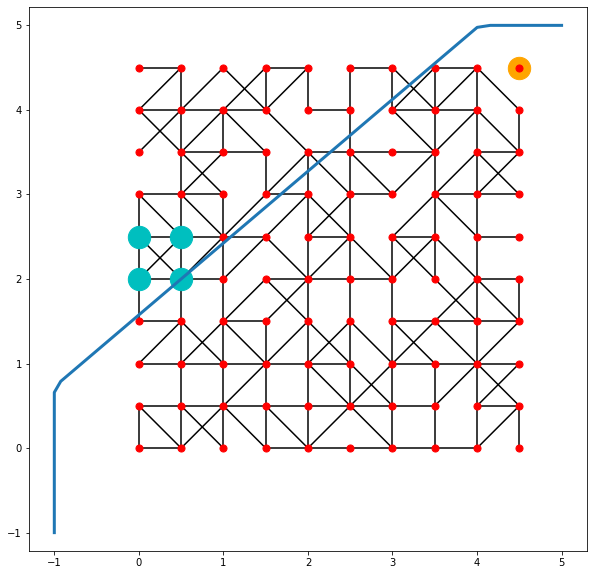

In [130]:
N = 10
sp = 0.5
np.random.seed(0)
points  = []
for i in range(N):
    for j in range(N):
        points.append(np.array([i*sp,j*sp]))
points = np.array(points)
ad_mat = np.zeros((N*N,N*N))
for i in range(N-1):
    for j in range(N-1):
        i1 = i + j*N
        i2 = i+1+ j*N
        i3 = i+1 +(j+1)*N
        i4 = i +(j+1)*N
        edges = np.where(np.random.rand(6)>0.5)[0]
        for e in edges:
            if e==0:
                ad_mat[i1,i2] =1
                ad_mat[i2,i1] =1
            if e==1:
                ad_mat[i2,i3] =1
                ad_mat[i3,i2] =1
            if e==2:
                ad_mat[i3,i4] =1
                ad_mat[i4,i3] =1
            if e==3:
                ad_mat[i4,i1] =1
                ad_mat[i1,i4] =1
            if e==4:
                ad_mat[i1,i3] =1
                ad_mat[i3,i1] =1
            if e==5:
                ad_mat[i2,i4] =1
                ad_mat[i4,i2] =1

# ad_mat[1,-1] = 1
# ad_mat[-1,1] = 1
# ad_mat[1,-2] = 1
# ad_mat[-2,1] = 1
# ad_mat[1,-3] = 1
# ad_mat[-3,1] = 1
# ad_mat[1,-4] = 1
# ad_mat[-4,1] = 1

# ad_mat[2,-1] = 1
# ad_mat[-1,2] = 1
# ad_mat[2,-2] = 1
# ad_mat[-2,2] = 1
# ad_mat[2,-3] = 1
# ad_mat[-3,2] = 1
# ad_mat[2,-4] = 1
# ad_mat[-4,2] = 1
ad_mat[4,5] = 1
ad_mat[5,4] = 1
fig,ax = plt.subplots(1,1, figsize = (10,10))
ax.scatter(points[:,0], points[:,1], s= 50, c = 'r', zorder = 3)


for i in range(len(points)-1):
    for j in range(i+1, len(points)):
        if ad_mat[i,j]:
            x = [points[i,0], points[j,0]]
            y = [points[i,1], points[j,1]]
            ax.plot(x,y, c = 'k')

#ax = plt.gca()
ax.set_xlim([-1,N*sp])
ax.set_ylim([-1,N*sp])
ax.axis('equal')
excl =99
success, v, lambdas, gammas = solve_prog(ad_mat, points, excl)
ax.scatter(points[excl, 0], points[excl,1], c = 'orange', s = 500, zorder =1)
lambdas = lambdas.squeeze()

print(f"{'success' if success else 'optimzation failed'}")
print('binary assignment: ', v)
print('lambda critical: ', lambdas)
print('gamma critical: ', gammas)
pts_idx = np.where(np.abs(v)>=1e-4)[0]
clique = np.array([points[i] for i in pts_idx])
ax.scatter(clique[:, 0], clique[:, 1], c = 'c', s = 500, zorder = 10)

hpts = np.clip(hyperplanepoints(lambdas), -1, (N)*sp)
ax.plot(hpts[:,0], hpts[:,1], linewidth = 3, zorder = 20)



In [32]:
from ellipse_utils import switch_ellipse_description

def compute_outer_LJ_sphere(pts):
    dim = pts[0].shape[0]
    # pts = #[pt1, pt2]
    # for _ in range(2*dim):
    #     m = 0.5*(pt1+pt2) + eps*(np.random.rand(2,1)-0.5)
    #     pts.append(m)
    upper_triangular_indeces = []
    for i in range(dim-1):
        for j in range(i+1, dim):
            upper_triangular_indeces.append([i,j])

    upper_triangular_indeces = np.array(upper_triangular_indeces)
    prog = MathematicalProgram()
    inv_radius = prog.NewContinuousVariables(1, 'rad')
    A = inv_radius*np.eye(dim)
    b = prog.NewContinuousVariables(dim, 'b')
    prog.AddMaximizeLogDeterminantCost(A)
    for idx, pt in enumerate(pts):
        pt = pt.reshape(dim,1)
        S = prog.NewSymmetricContinuousVariables(dim+1, 'S')
        prog.AddPositiveSemidefiniteConstraint(S)
        prog.AddLinearEqualityConstraint(S[0,0] == 0.9)
        v = (A@pt + b.reshape(dim,1)).T
        c = (S[1:,1:]-np.eye(dim)).reshape(-1)
        for idx in range(dim):
            prog.AddLinearEqualityConstraint(S[0,1 + idx]-v[0,idx], 0 )
        for ci in c:
            prog.AddLinearEqualityConstraint(ci, 0 )

    prog.AddPositiveSemidefiniteConstraint(A) # eps * identity

    # for aij in A[upper_triangular_indeces[:,0], upper_triangular_indeces[:,1]]:
    #     prog.AddLinearConstraint(aij == 0)
    prog.AddPositiveSemidefiniteConstraint(10000*np.eye(dim)-A)

    sol = Solve(prog)
    if sol.is_success():
        HE, _, _ =switch_ellipse_description(sol.GetSolution(inv_radius)*np.eye(dim), sol.GetSolution(b))
    return HE


# ang = np.linspace(0, 2*np.pi, 100)
# pts = 2*np.array([[np.cos(ang)],[np.sin(ang)]]).squeeze().T

# HE = compute_outer_LJ_sphere(pts) 

# import matplotlib.pyplot as plt
# from ellipse_utils import plot_ellipse

# fig, ax = plt.subplots(1,1)
# ax.scatter(pts[:,0], pts[:,1])
# plot_ellipse(ax, HE, 100)

def max_clique_w_exclusion_points(adj_mat, graph_vertices, points_to_exclude):
    assert adj_mat.shape[0] == len(graph_vertices)
    assert graph_vertices[0, :].shape[0] == points_to_exclude.shape[1]
    
    dim = graph_vertices.shape[1]
    #compute radius of circumscribed sphere of all points to get soft margin size
    HS = compute_outer_LJ_sphere(np.concatenate((graph_vertices, points_to_exclude), axis=0))
    radius = 2*1/(HS.A()[0,0]+1e-6)
    n = adj_mat.shape[0]
    num_points_to_exclude = points_to_exclude.shape[0]


    prog = MathematicalProgram()
    v = prog.NewBinaryVariables(n)
    prog.AddLinearCost(-np.sum(v))
    
    #hyperplanes
    lambdas = prog.NewContinuousVariables(num_points_to_exclude, dim+1)
    #slack variables for soft margins
    gammas = prog.NewContinuousVariables(num_points_to_exclude, n)

    Points_mat = np.concatenate((points,np.ones((n,1))), axis =1)
    Exclusion_points_mat =  np.concatenate((points_to_exclude,np.ones((num_points_to_exclude,1))), axis =1)

    for i in range(0,n):
        for j in range(i+1,n):
            if ad_mat[i,j] == 0:
                prog.AddLinearConstraint(v[i] + v[j] <= 1)

    for i in range(num_points_to_exclude):
        constraint1 = -Points_mat@lambdas[i,:]+2*radius*gammas[i,:]
        constraint2 = Exclusion_points_mat[i,:]@lambdas[i,:]  #+ np.sum(gammas)
        for k in range(n):
            prog.AddLinearConstraint(constraint1[k] >=0)

        prog.AddLinearConstraint(constraint2>=1) #-v[point_to_exclude]

    for i in range(num_points_to_exclude):
        gammas_point_i = gammas[i, :]    
        for vi, gi in zip(v, gammas_point_i):
            prog.AddLinearConstraint(gi >= (vi-1))

        for vi,gi in zip(v, gammas_point_i):
            prog.AddLinearConstraint((1-vi)>= gi )


    solver_options = SolverOptions()
    solver_options.SetOption(CommonSolverOption.kPrintToConsole, 1)

    result = Solve(prog, solver_options=solver_options)
    return result.is_success(), result.GetSolution(v), result.GetSolution(lambdas), result.GetSolution(gammas)
    

average time = 0.18 over 10 tries, with 5 points excluded, on a graph of size 100
success
binary assignment:  [-0.  0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0.  0.  1.  0.  1.  0.  0.
  0. -0. -0.  0. -0.  1. -0. -0. -0.  1. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0.  0. -0. -0. -0.  0. -0.  0. -0. -0. -0. -0. -0. -0.  0. -0. -0.
 -0.  1. -0.  0. -0. -0. -0. -0.  0. -0. -0. -0.  1. -0.  0. -0. -0. -0.
 -0. -0. -0.  0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0.
  0. -0. -0. -0. -0. -0. -0.  0. -0. -0.]
lambda critical:  [[  2.           0.          -8.        ]
 [  0.          24.83272677 -98.33090706]
 [-24.83272677  -1.          13.41636338]
 [  0.          -2.           3.        ]
 [  0.28571429  12.41636338 -43.74298613]]


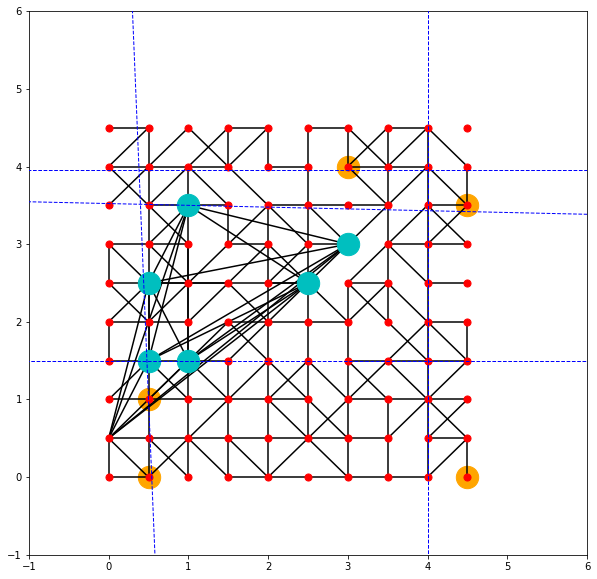

In [248]:
N = 10
sp = 0.5
np.random.seed(0)
points  = []
for i in range(N):
    for j in range(N):
        points.append(np.array([i*sp,j*sp]))
points = np.array(points)
ad_mat = np.zeros((N*N,N*N))
for i in range(N-1):
    for j in range(N-1):
        i1 = i + j*N
        i2 = i+1+ j*N
        i3 = i+1 +(j+1)*N
        i4 = i +(j+1)*N
        edges = np.where(np.random.rand(6)>0.5)[0]
        for e in edges:
            if e==0:
                ad_mat[i1,i2] =1
                ad_mat[i2,i1] =1
            if e==1:
                ad_mat[i2,i3] =1
                ad_mat[i3,i2] =1
            if e==2:
                ad_mat[i3,i4] =1
                ad_mat[i4,i3] =1
            if e==3:
                ad_mat[i4,i1] =1
                ad_mat[i1,i4] =1
            if e==4:
                ad_mat[i1,i3] =1
                ad_mat[i3,i1] =1
            if e==5:
                ad_mat[i2,i4] =1
                ad_mat[i4,i2] =1

# ad_mat[1,-1] = 1
# ad_mat[-1,1] = 1
# ad_mat[1,-2] = 1
# ad_mat[-2,1] = 1
# ad_mat[1,-3] = 1
# ad_mat[-3,1] = 1
# ad_mat[1,-4] = 1
# ad_mat[-4,1] = 1

# ad_mat[2,-1] = 1
# ad_mat[-1,2] = 1
# ad_mat[2,-2] = 1
# ad_mat[-2,2] = 1
# ad_mat[2,-3] = 1
# ad_mat[-3,2] = 1
# ad_mat[2,-4] = 1
# ad_mat[-4,2] = 1
clique = [1, 13, 23, 15, 27, 55, 66]
for i,c in enumerate(clique[:-1]):
    for c2 in clique[i+1:]:
        ad_mat[c,c2] = 1
        ad_mat[c2,c] = 1

fig,ax = plt.subplots(1,1, figsize = (10,10))
ax.scatter(points[:,0], points[:,1], s= 50, c = 'r', zorder = 3)


for i in range(len(points)-1):
    for j in range(i+1, len(points)):
        if ad_mat[i,j]:
            x = [points[i,0], points[j,0]]
            y = [points[i,1], points[j,1]]
            ax.plot(x,y, c = 'k')

#ax = plt.gca()
ax.set_xlim([-1,1+N*sp])
ax.set_ylim([-1,1+N*sp])
#ax.axis('equal')
#excl =99
excl = 5
points_to_exclude =  points[np.random.choice(N**2,excl), :]

import time
tries = 10
t1 = time.time()
for _ in range(tries):
    success, v, lambdas, gammas = max_clique_w_exclusion_points(ad_mat, points, points_to_exclude)
t2 = time.time()
print(f"average time = {(t2-t1)/tries:.2f} over {tries} tries, with {excl} points excluded, on a graph of size {N**2}")

ax.scatter(points_to_exclude[:, 0], points_to_exclude[:,1], c = 'orange', s = 500, zorder =1)
#lambdas = lambdas.squeeze()

print(f"{'success' if success else 'optimzation failed'}")
print('binary assignment: ', v)
print('lambda critical: ', lambdas)
#print('gamma critical: ', gammas)
pts_idx = np.where(np.abs(v)>=1e-4)[0]
clique = np.array([points[i] for i in pts_idx])
ax.scatter(clique[:, 0], clique[:, 1], c = 'c', s = 500, zorder = 10)

for i in range(lambdas.shape[0]):
    lamb = lambdas[i,:]
    hpts = hyperplanepoints(lamb)#np.clip(hyperplanepoints(lamb), -1, (N)*sp)
    ax.plot(hpts[:,0], hpts[:,1], linewidth = 1, linestyle = '--', c= 'b', zorder = 20)

100%|██████████| 11/11 [00:00<00:00, 1151.71it/s]


True
[ 1.  1.  0.  0.  1.  0.  0.  1.  0. -0.]
[[-0.  1. -0. -0. -0. -0. -0.  0. -0.  0.]
 [-0. -0. -0.  0.  0. -0. -0.  1. -0. -0.]
 [ 0.  0. -0. -0.  1. -0. -0. -0. -0. -0.]
 [ 0. -0. -0.  0. -0. -0.  0.  1. -0.  0.]
 [-0.  0. -0. -0.  0. -0. -0.  1. -0. -0.]
 [ 0. -0. -0. -0.  0. -0. -0.  1. -0. -0.]
 [ 0.  1. -0. -0.  0. -0. -0. -0. -0. -0.]
 [ 0.  1. -0. -0.  0. -0. -0. -0. -0. -0.]
 [ 1. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
 [ 0.  1.  0.  0. -0.  0. -0. -0. -0.  0.]
 [ 0.  0.  0.  0.  1. -0. -0.  0. -0.  0.]]


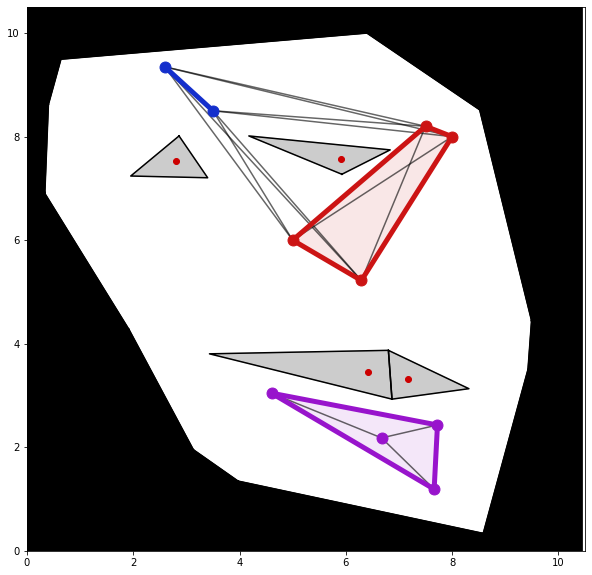

In [211]:
#CGSHOP example
from cgdataset import World
import matplotlib.pyplot as plt
import numpy as np
world = World('data/evalexamples/cheese102_short_red.instance.json')
offs = -0.3
world.build_offset_cfree(offs)
from seeding_utils import point_in_regions, point_near_regions, vis_reg, compute_kernels
from scipy.sparse import lil_matrix
from tqdm import tqdm
def sample_cfree_handle(n, m, regions=None):
    points = np.zeros((n,2))
    if regions is None: regions = []		
    for i in range(n):
        bt_tries = 0
        while bt_tries<m:
            point = world.sample_cfree_distance(1, offs)[0]
            #point = world.sample_cfree(1)[0]
            if point_near_regions(point, regions, tries = 100, eps = 0.1):
                bt_tries+=1
            else:
                break
        if bt_tries == m:
            return points, True
        
        points[i] = point
    return points, False

def vgraph_builder(points):
    n = len(points)
    adj_mat = lil_matrix((n,n))
    for i in tqdm(range(n)):
        point = points[i, :]
        for j in range(len(points[:i])):
            other = points[j]
            # if region_vis_obstacles:
            # 	if vis_reg(point, other, world, []):
            # 		adj_mat[i,j] = adj_mat[j,i] = 1
            # else:
            if  vis_reg(point, other, world, []):
                adj_mat[i,j] = adj_mat[j,i] = 1
    return adj_mat.toarray()

from scipy.spatial import ConvexHull
from pydrake.all import VPolytope

def seed_poly_hulls(cliques, pts):
    seed_polys = []
    for c in cliques:
        if len(c)>= 3:
            pts_clique = pts[c,:]
            hull = ConvexHull(pts_clique)
            hull_vertices = pts_clique[hull.vertices, :]
            seed_polys.append(VPolytope(hull_vertices.T))
        else:
            seed_polys.append(None)
    return seed_polys

from utils import generate_maximally_different_colors
from seeding_utils import sorted_vertices

def plot_polys(seed_polys, cliques, pts, ax, colors):
    
    for idx, c in enumerate(cliques):
        colc = colors[idx]
        seed_pol = seed_polys[idx]
        scatter_plot = ax.scatter(pts[c, 0], pts[c, 1], s = 120, color = colc)
        #add edges from the center of each clique
        # for ci in c[1:]:
        #     ax.plot([pts[center,0], pts[ci,0]],[pts[center,1], pts[ci,1]], linewidth=1, c = colc)

        if seed_pol is not None:    
            v = sorted_vertices(seed_pol).T#s
            v = np.concatenate((v, v[0,:].reshape(1,-1)), axis=0)
            p = ax.plot(v[:,0], v[:,1], linewidth = 5, c = colc, zorder = 0)

            ax.fill(v[:,0], v[:,1], alpha = 0.1, c = p[0].get_color(), zorder = 0)
        else:
            ax.plot(pts[c, 0], pts[c, 1], linewidth = 5, c = colc)

fig, ax = plt.subplots(1,1, figsize = (10,10))
world.plot_cfree_skel(ax)
ax.set_xlim([-0,10.5])
ax.set_ylim([-0,10.5])
counter_examples = []
for h in world.holes_tri:
    vol = h.MaximumVolumeInscribedEllipsoid().Volume()
    if vol > 1e-5:
        counter_examples.append(h.ChebyshevCenter())
counter_examples = np.array(counter_examples)
ax.scatter(counter_examples[:,0], counter_examples[:,1], c = 'r')
np.random.seed(18)
pts, _ = sample_cfree_handle(9, 3000, [])
pts = pts[[0,2,4,5,7,8], :]
aux = np.array([[8,8],
                [7.5, 8.2],
                [9, 7],
                [5,6],
                [3.5,8.5]])
pts = np.concatenate((pts, aux), axis = 0)
ax.scatter(pts[:, 0], pts[:, 1], c = 'k')
ad_mat = vgraph_builder(pts)
#cliques, w, b = min_clique_cover(ad_mat, pts)
cliques, w, b, h, result, lambdas = min_clique_cover_sep(ad_mat, pts, counter_examples)
colors = [generate_maximally_different_colors(len(cliques)+10)[i] for i in [0,5,7,4]]
# for col, c_hyps in zip(colors,h):
#     for h in c_hyps:
#         hpts = hyperplanepoints(h)
#         ax.plot(hpts[:,0], hpts[:,1], linewidth = 1, linestyle = '--', c= col, zorder = 20)
for i in range(pts.shape[0]-1):
    for j in range(i+1, pts.shape[0]):
        if ad_mat[i,j] ==1:
            plt.plot(pts[[i,j], 0], pts[[i,j], 1], c = 'k', alpha = 0.6, zorder = 0)

# print(cliques)
# print(w.reshape(1,-1))
# print(b)
# print(b.sum(axis =1))
# print(ad_mat)
seed_polys = seed_poly_hulls(cliques, pts)
plot_polys(seed_polys, cliques, pts, ax, colors)
plt.savefig('hyp.pdf')


In [120]:
result.GetSolution(lambdas[0])

array([[  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  1.33278278,   5.11954498, -41.31859982]])

In [45]:
seed_polys

 None,
 None,
 None]

In [2]:
from pydrake.all import MathematicalProgram, CommonSolverOption, SolverOptions, Solve

def min_clique_cover(adj_mat, vertices):
    assert adj_mat.shape[0] == len(vertices)
    dim = vertices.shape[1]
    n = adj_mat.shape[0]
    prog = MathematicalProgram()
    b = prog.NewBinaryVariables(n, 10)
    w = prog.NewBinaryVariables(10)
    prog.AddLinearCost(np.sum(w))
    prog.AddLinearConstraint(w[0]==1)
    for i in range(n):
        prog.AddLinearConstraint(np.sum(b[i,:]) ==1)
    for c in range(b.shape[1]):
        for i in range(0,n):
            for j in range(i+1,n):
                if ad_mat[i,j] == 0:
                    prog.AddLinearConstraint(b[i, c] + b[j, c] <= w[c])
    solver_options = SolverOptions()
    solver_options.SetOption(CommonSolverOption.kPrintToConsole, 1)

    result = Solve(prog, solver_options=solver_options)
    print(result.is_success())
    w_sol = result.GetSolution(w)
    b_sol = result.GetSolution(b)
    used_cliques = np.where(w_sol > 0.9)[0]
    cliques = []
    for c in used_cliques:
        cliques.append(np.where(b_sol[:,c]==1)[0])

    return cliques, w_sol, b_sol


def min_clique_cover_sep(adj_mat, vertices, excl_points):
    assert adj_mat.shape[0] == len(vertices)
    assert vertices[0, :].shape[0] == excl_points.shape[1]
    H = 10
    dim = vertices.shape[1]
    n = adj_mat.shape[0]
    M = 10
    num_points_to_exclude = excl_points.shape[0]
    prog = MathematicalProgram()
    b = prog.NewBinaryVariables(n, H)
    w = prog.NewBinaryVariables(H)
    prog.AddLinearCost(np.sum(w))
    
    
    for i in range(n):
        prog.AddLinearConstraint(np.sum(b[i,:]) ==1)
    
    for c in range(len(w)):
        for i in range(n):
            prog.AddLinearConstraint(b[i,c]<=w[c])
    
    for c in range(b.shape[1]):
        for i in range(0,n):
            for j in range(i+1,n):
                if ad_mat[i,j] == 0:
                    prog.AddLinearConstraint(b[i, c] + b[j, c] <= w[c])

    #hyperplanes
    lambdas = [prog.NewContinuousVariables(num_points_to_exclude, dim+1) for i in range(H)]
    #slack variables for soft margins
    gammas = [prog.NewContinuousVariables(num_points_to_exclude, n) for i in range(H)]
    
    Points_mat = np.concatenate((vertices,np.ones((n,1))), axis =1)
    Exclusion_points_mat =  np.concatenate((excl_points,np.ones((num_points_to_exclude,1))), axis =1)

    for c, (lamb, gam) in enumerate(zip(lambdas, gammas)):
        for i in range(num_points_to_exclude):    
            constraint1 = -Points_mat@lamb[i,:]+M*gam[i,:]
            constraint2 = Exclusion_points_mat[i,:]@lamb[i,:]  #+ np.sum(gammas)
            for k in range(n):
                prog.AddLinearConstraint(constraint1[k] >=0)

            prog.AddLinearConstraint(constraint2>=1)
            
        for i in range(num_points_to_exclude):
            gammas_point_i = gam[i, :]    
            for bi, gi in zip(b[:,c], gammas_point_i):
                prog.AddLinearConstraint(gi >= (bi-1))

            for bi,gi in zip(b[:,c], gammas_point_i):
                prog.AddLinearConstraint((1-bi)>= gi )

    solver_options = SolverOptions()
    solver_options.SetOption(CommonSolverOption.kPrintToConsole, 1)

    result = Solve(prog, solver_options=solver_options)
    print(result.is_success())
    w_sol = result.GetSolution(w)
    b_sol = result.GetSolution(b)
    print(w_sol)
    print(b_sol)
    
    used_cliques = np.where(w_sol > 0.9)[0]

    hyperplanes = [result.GetSolution(lambdas[i]) for i in used_cliques]
    
    cliques = []
    for c in used_cliques:
        cliques.append(np.where(b_sol[:,c]==1)[0])

    return cliques, w_sol, b_sol, hyperplanes, result, lambdas

# def max_clique_w_exclusion_points(adj_mat, graph_vertices, points_to_exclude):
#     assert adj_mat.shape[0] == len(graph_vertices)
#     assert graph_vertices[0, :].shape[0] == points_to_exclude.shape[1]
    
#     dim = graph_vertices.shape[1]
#     #compute radius of circumscribed sphere of all points to get soft margin size
#     HS = compute_outer_LJ_sphere(np.concatenate((graph_vertices, points_to_exclude), axis=0))
#     radius = 2*1/(HS.A()[0,0]+1e-6)
#     n = adj_mat.shape[0]
#     num_points_to_exclude = points_to_exclude.shape[0]


#     prog = MathematicalProgram()
#     v = prog.NewBinaryVariables(n)
#     prog.AddLinearCost(-np.sum(v))
    
#     #hyperplanes
#     lambdas = prog.NewContinuousVariables(num_points_to_exclude, dim+1)
#     #slack variables for soft margins
#     gammas = prog.NewContinuousVariables(num_points_to_exclude, n)

#     Points_mat = np.concatenate((points,np.ones((n,1))), axis =1)
#     Exclusion_points_mat =  np.concatenate((points_to_exclude,np.ones((num_points_to_exclude,1))), axis =1)

#     for i in range(0,n):
#         for j in range(i+1,n):
#             if ad_mat[i,j] == 0:
#                 prog.AddLinearConstraint(v[i] + v[j] <= 1)

#     for i in range(num_points_to_exclude):
#         constraint1 = -Points_mat@lambdas[i,:]+2*radius*gammas[i,:]
#         constraint2 = Exclusion_points_mat[i,:]@lambdas[i,:]  #+ np.sum(gammas)
#         for k in range(n):
#             prog.AddLinearConstraint(constraint1[k] >=0)

#         prog.AddLinearConstraint(constraint2>=1) #-v[point_to_exclude]

#     for i in range(num_points_to_exclude):
#         gammas_point_i = gammas[i, :]    
#         for vi, gi in zip(v, gammas_point_i):
#             prog.AddLinearConstraint(gi >= (vi-1))

#         for vi,gi in zip(v, gammas_point_i):
#             prog.AddLinearConstraint((1-vi)>= gi )


#     solver_options = SolverOptions()
#     solver_options.SetOption(CommonSolverOption.kPrintToConsole, 1)

#     result = Solve(prog, solver_options=solver_options)
#     return result.is_success(), result.GetSolution(v), result.GetSolution(lambdas), result.GetSolution(gammas)

100%|██████████| 14/14 [00:00<00:00, 565.96it/s]


True
2


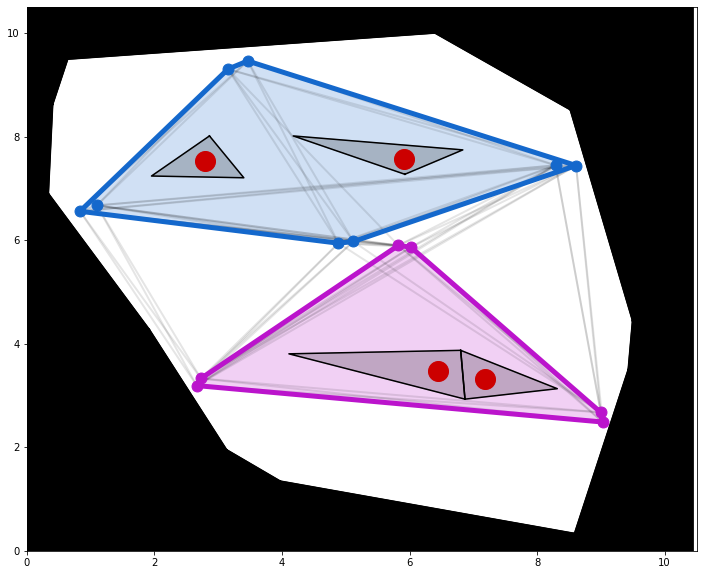

In [25]:
#CGSHOP example
from cgdataset import World
import matplotlib.pyplot as plt
import numpy as np
world = World('data/evalexamples/cheese102_short_red.instance.json')
offs = -0.1
world.build_offset_cfree(offs)
from seeding_utils import point_in_regions, point_near_regions, vis_reg, compute_kernels
from scipy.sparse import lil_matrix
from tqdm import tqdm
def sample_cfree_handle(n, m, regions=None):
    points = np.zeros((n,2))
    if regions is None: regions = []		
    for i in range(n):
        bt_tries = 0
        while bt_tries<m:
            point = world.sample_cfree_distance(1, offs)[0]
            #point = world.sample_cfree(1)[0]
            if point_near_regions(point, regions, tries = 100, eps = 0.1):
                bt_tries+=1
            else:
                break
        if bt_tries == m:
            return points, True
        
        points[i] = point
    return points, False

def vgraph_builder(points):
    n = len(points)
    adj_mat = lil_matrix((n,n))
    for i in tqdm(range(n)):
        point = points[i, :]
        for j in range(len(points[:i])):
            other = points[j]
            # if region_vis_obstacles:
            # 	if vis_reg(point, other, world, []):
            # 		adj_mat[i,j] = adj_mat[j,i] = 1
            # else:
            if  vis_reg(point, other, world, []):
                adj_mat[i,j] = adj_mat[j,i] = 1
    return adj_mat.toarray()

from scipy.spatial import ConvexHull
from pydrake.all import VPolytope

def seed_poly_hulls(cliques, pts):
    seed_polys = []
    for c in cliques:
        if len(c)>= 3:
            pts_clique = pts[c,:]
            hull = ConvexHull(pts_clique)
            hull_vertices = pts_clique[hull.vertices, :]
            seed_polys.append(VPolytope(hull_vertices.T))
        else:
            seed_polys.append(None)
    return seed_polys

from utils import generate_maximally_different_colors
from seeding_utils import sorted_vertices

def plot_polys(seed_polys, cliques, pts, ax, colors):
    
    for idx, c in enumerate(cliques):
        colc = colors[idx]
        seed_pol = seed_polys[idx]
        scatter_plot = ax.scatter(pts[c, 0], pts[c, 1], s = 120, color = colc)
        #add edges from the center of each clique
        # for ci in c[1:]:
        #     ax.plot([pts[center,0], pts[ci,0]],[pts[center,1], pts[ci,1]], linewidth=1, c = colc)

        if seed_pol is not None:    
            v = sorted_vertices(seed_pol).T#s
            v = np.concatenate((v, v[0,:].reshape(1,-1)), axis=0)
            p = ax.plot(v[:,0], v[:,1], linewidth = 5, c = colc, zorder = 0)

            ax.fill(v[:,0], v[:,1], alpha = 0.2, c = p[0].get_color(), zorder = 0)
        else:
            ax.plot(pts[c, 0], pts[c, 1], linewidth = 5, c = colc)

fig, ax = plt.subplots(1,1, figsize = (12,10))
world.plot_cfree_skel(ax)
ax.set_xlim([-0,10.5])
ax.set_ylim([-0,10.5])
counter_examples = []
for h in world.holes_tri:
    vol = h.MaximumVolumeInscribedEllipsoid().Volume()
    if vol > 1e-5:
        counter_examples.append(h.ChebyshevCenter())
counter_examples = np.array(counter_examples)
ax.scatter(counter_examples[:,0], counter_examples[:,1], c = 'r', s = 400)
np.random.seed(25)
pts, _ = sample_cfree_handle(1, 3000, [])
pts_lower = pts
pts, _ = sample_cfree_handle(1, 3000, [])
pts_lower2 = pts[np.where(pts[:,1]<=4.5)[0], :]
# pts, _ = sample_cfree_handle(5, 3000, [])
# pts_upper = pts[np.where(pts[:,1]>=5.5)[0], :]
#pts2 = pts[[0,2,4,5,7,8], :]
cluster = np.array([[3.3,9.3], [0.99,6.6], [8.45,7.4], [2.7,3.2],[5,6],[6,6],[9,2.5]])
pc = []
for c in cluster:
    for idx in range(2):
        pc+=[0.4*(np.random.rand(2)-0.5) +c]
pc = np.array(pc)
pts = pc# np.concatenate((pts_lower,pts_lower2,pc), axis = 0)
#pts = np.delete(pts, [14,19], axis = 0)
ax.scatter(pts[:, 0], pts[:, 1], c = 'k')
ad_mat = vgraph_builder(pts)
cliques, w, b = min_clique_cover(ad_mat, pts)
#cliques, w, b, h, result, lambdas = min_clique_cover_sep(ad_mat, pts, counter_examples)
colors = generate_maximally_different_colors(len(cliques)+20)[20:]#[generate_maximally_different_colors(len(cliques)+10)[i] for i in [0,5,7,4]]
# for col, c_hyps in zip(colors,h):
#     for h in c_hyps:
#         hpts = hyperplanepoints(h)
#         ax.plot(hpts[:,0], hpts[:,1], linewidth = 1, linestyle = '--', c= col, zorder = 20)
for i in range(pts.shape[0]-1):
    for j in range(i+1, pts.shape[0]):
        if ad_mat[i,j] ==1:
            plt.plot(pts[[i,j], 0], pts[[i,j], 1], c = 'k', alpha = 0.1, linewidth = 2, zorder = 0)

# print(cliques)
# print(w.reshape(1,-1))
# print(b)
# print(b.sum(axis =1))
# print(ad_mat)
seed_polys = seed_poly_hulls(cliques, pts)
plot_polys(seed_polys, cliques, pts, ax, colors)
plt.savefig('hyp.pdf')
print(len(cliques))

In [9]:
from pydrake.all import MathematicalProgram, CommonSolverOption, SolverOptions, Solve
from ellipse_utils import switch_ellipse_description

def compute_outer_LJ_sphere(pts):
    dim = pts[0].shape[0]
    # pts = #[pt1, pt2]
    # for _ in range(2*dim):
    #     m = 0.5*(pt1+pt2) + eps*(np.random.rand(2,1)-0.5)
    #     pts.append(m)
    upper_triangular_indeces = []
    for i in range(dim-1):
        for j in range(i+1, dim):
            upper_triangular_indeces.append([i,j])

    upper_triangular_indeces = np.array(upper_triangular_indeces)
    prog = MathematicalProgram()
    inv_radius = prog.NewContinuousVariables(1, 'rad')
    A = inv_radius*np.eye(dim)
    b = prog.NewContinuousVariables(dim, 'b')
    prog.AddMaximizeLogDeterminantCost(A)
    for idx, pt in enumerate(pts):
        pt = pt.reshape(dim,1)
        S = prog.NewSymmetricContinuousVariables(dim+1, 'S')
        prog.AddPositiveSemidefiniteConstraint(S)
        prog.AddLinearEqualityConstraint(S[0,0] == 0.9)
        v = (A@pt + b.reshape(dim,1)).T
        c = (S[1:,1:]-np.eye(dim)).reshape(-1)
        for idx in range(dim):
            prog.AddLinearEqualityConstraint(S[0,1 + idx]-v[0,idx], 0 )
        for ci in c:
            prog.AddLinearEqualityConstraint(ci, 0 )

    prog.AddPositiveSemidefiniteConstraint(A) # eps * identity

    # for aij in A[upper_triangular_indeces[:,0], upper_triangular_indeces[:,1]]:
    #     prog.AddLinearConstraint(aij == 0)
    prog.AddPositiveSemidefiniteConstraint(10000*np.eye(dim)-A)

    sol = Solve(prog)
    if sol.is_success():
        HE, _, _ =switch_ellipse_description(sol.GetSolution(inv_radius)*np.eye(dim), sol.GetSolution(b))
    return HE


def max_clique(adj_mat):
    #assert adj_mat.shape[0] == len(graph_vertices)
    #assert graph_vertices[0, :].shape[0] == points_to_exclude.shape[1]
    
    #dim = graph_vertices.shape[1]
    #compute radius of circumscribed sphere of all points to get soft margin size
    n = adj_mat.shape[0]
    
    prog = MathematicalProgram()
    v = prog.NewBinaryVariables(n)
    prog.AddLinearCost(-np.sum(v))
    
    
    for i in range(0,n):
        for j in range(i+1,n):
            if ad_mat[i,j] == 0:
                prog.AddLinearConstraint(v[i] + v[j] <= 1)

    solver_options = SolverOptions()
    solver_options.SetOption(CommonSolverOption.kPrintToConsole, 1)

    result = Solve(prog, solver_options=solver_options)
    print(result.is_success())
    return np.where(result.GetSolution(v)==1)[0], None, None

def max_clique_w_cvx_hull_constraint(adj_mat, graph_vertices):
    assert adj_mat.shape[0] == len(graph_vertices)
    #assert graph_vertices[0, :].shape[0] == points_to_exclude.shape[1]
    
    dim = graph_vertices.shape[1]
    #compute radius of circumscribed sphere of all points to get soft margin size
    HS = compute_outer_LJ_sphere(graph_vertices)
    radius = 2*1/(HS.A()[0,0]+1e-6)
    n = adj_mat.shape[0]
    
    prog = MathematicalProgram()
    v = prog.NewBinaryVariables(n)
    prog.AddLinearCost(-np.sum(v))
    
    #hyperplanes
    lambdas = prog.NewContinuousVariables(n, dim+1)
    #slack variables for soft margins
    gammas = prog.NewContinuousVariables(n, n)

    Points_mat = np.concatenate((graph_vertices,np.ones((n,1))), axis =1)
    #Exclusion_points_mat =  np.concatenate((points_to_exclude,np.ones((num_points_to_exclude,1))), axis =1)

    for i in range(0,n):
        for j in range(i+1,n):
            if ad_mat[i,j] == 0:
                prog.AddLinearConstraint(v[i] + v[j] <= 1)

    for i in range(n):
        constraint1 = -Points_mat@lambdas[i,:]+2*radius*gammas[i,:]
        constraint2 = Points_mat[i,:]@lambdas[i,:]  #+ np.sum(gammas)
        for k in range(n):
            prog.AddLinearConstraint(constraint1[k] >=0)

        prog.AddLinearConstraint(constraint2>=1-v[i]) #

    for i in range(n):
        gammas_point_i = gammas[i, :]    
        for vi, gi in zip(v, gammas_point_i):
            prog.AddLinearConstraint(gi >= (vi-1))

        for vi,gi in zip(v, gammas_point_i):
            prog.AddLinearConstraint((1-vi)>= gi )


    solver_options = SolverOptions()
    solver_options.SetOption(CommonSolverOption.kPrintToConsole, 1)

    result = Solve(prog, solver_options=solver_options)
    print(result.is_success())
    return np.where(result.GetSolution(v)==1)[0], result.GetSolution(lambdas), result.GetSolution(gammas)

100%|██████████| 100/100 [00:01<00:00, 82.53it/s]


True
True
[ 0  3  4  5  7  9 10 11 12 13 15 16 18 20 21 22 23 26 27 28 29 31 32 33
 34 35 37 38 39 40 41 43 47 48 50 52 53 54 55 59 60 61 62 64 66 68 70 71
 74 75 76 77 78 79 80 81 84 85 90 93 94 98 99]
[ 0  3  4  6  9 10 11 13 14 15 16 17 18 21 23 25 27 28 31 33 36 38 39 40
 41 42 43 45 51 52 53 58 60 61 64 65 66 68 70 71 74 75 76 77 78 79 80 85
 86 91 92 93 94 96 97 99]
63
56


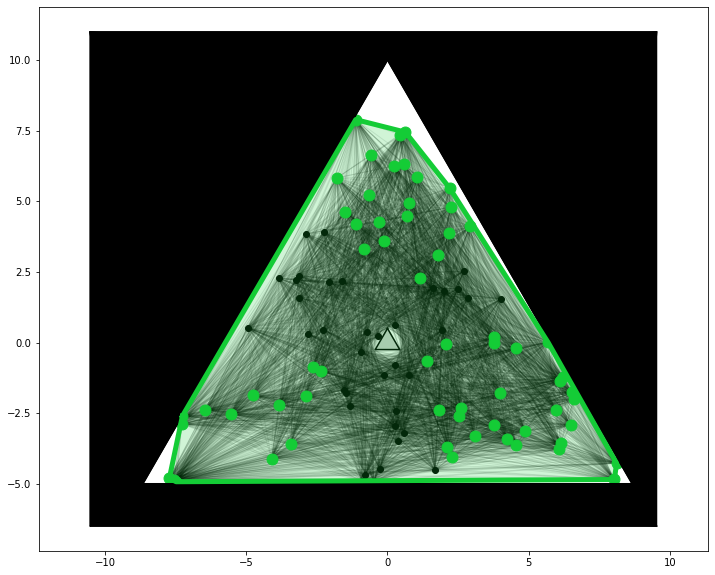

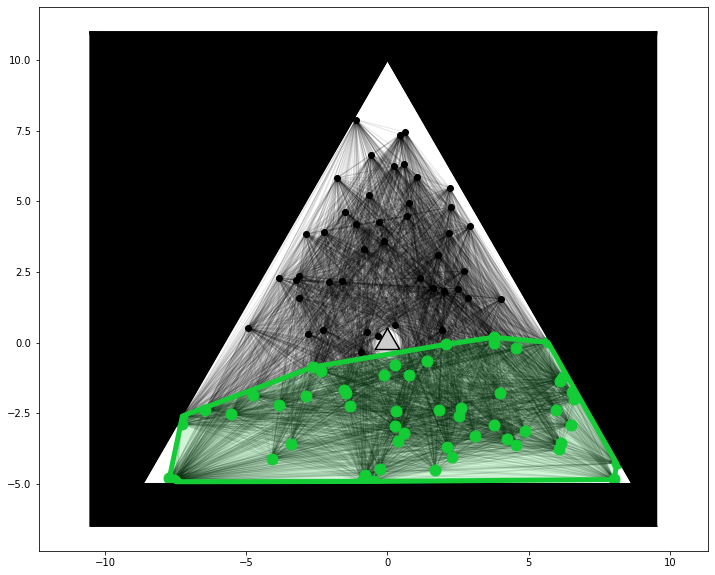

In [13]:
#CGSHOP example
from cgdataset import World
import matplotlib.pyplot as plt
import numpy as np
world = World('data/evalexamples/triangle.json')
offs = -0.01
world.build_offset_cfree(offs)
from seeding_utils import point_in_regions, point_near_regions, vis_reg, compute_kernels
from scipy.sparse import lil_matrix
from tqdm import tqdm
def sample_cfree_handle(n, m, regions=None):
    points = np.zeros((n,2))
    if regions is None: regions = []		
    for i in range(n):
        bt_tries = 0
        while bt_tries<m:
            point = world.sample_cfree_distance(1, offs)[0]
            #point = world.sample_cfree(1)[0]
            if point_near_regions(point, regions, tries = 100, eps = 0.1):
                bt_tries+=1
            else:
                break
        if bt_tries == m:
            return points, True
        
        points[i] = point
    return points, False

def vgraph_builder(points):
    n = len(points)
    adj_mat = lil_matrix((n,n))
    for i in tqdm(range(n)):
        point = points[i, :]
        for j in range(len(points[:i])):
            other = points[j]
            # if region_vis_obstacles:
            # 	if vis_reg(point, other, world, []):
            # 		adj_mat[i,j] = adj_mat[j,i] = 1
            # else:
            if  vis_reg(point, other, world, []):
                adj_mat[i,j] = adj_mat[j,i] = 1
    return adj_mat.toarray()

from scipy.spatial import ConvexHull
from pydrake.all import VPolytope

def seed_poly_hulls(cliques, pts):
    seed_polys = []
    for c in cliques:
        print(c)
        if len(c)>= 3:
            pts_clique = pts[c,:]
            hull = ConvexHull(pts_clique)
            hull_vertices = pts_clique[hull.vertices, :]
            seed_polys.append(VPolytope(hull_vertices.T))
        else:
            seed_polys.append(None)
    return seed_polys

from utils import generate_maximally_different_colors
from seeding_utils import sorted_vertices

def plot_polys(seed_polys, cliques, pts, ax, colors):
    
    for idx, c in enumerate(cliques):
        colc = colors[idx]
        seed_pol = seed_polys[idx]
        scatter_plot = ax.scatter(pts[c, 0], pts[c, 1], s = 120*(len(cliques)-1.2*idx)/len(cliques), color = colc)
        #add edges from the center of each clique
        # for ci in c[1:]:
        #     ax.plot([pts[center,0], pts[ci,0]],[pts[center,1], pts[ci,1]], linewidth=1, c = colc)

        if seed_pol is not None:    
            v = sorted_vertices(seed_pol).T#s
            v = np.concatenate((v, v[0,:].reshape(1,-1)), axis=0)
            p = ax.plot(v[:,0], v[:,1], linewidth = 5, c = colc, zorder = 5)

            ax.fill(v[:,0], v[:,1], alpha = 0.2, c = p[0].get_color(), zorder = 5)
        else:
            ax.plot(pts[c, 0], pts[c, 1], linewidth = 5, c = colc)


#ax.set_xlim([-0,10.5])
#ax.set_ylim([-0,10.5])
counter_examples = []
for h in world.holes_tri:
    vol = h.MaximumVolumeInscribedEllipsoid().Volume()
    if vol > 1e-5:
        counter_examples.append(h.ChebyshevCenter())
counter_examples = np.array(counter_examples)
#ax.scatter(counter_examples[:,0], counter_examples[:,1], c = 'r', s = 400)
np.random.seed(25)
pts, _ = sample_cfree_handle(100, 3000, [])
# pts_lower = pts
# pts, _ = sample_cfree_handle(1, 3000, [])
#pts = pts[np.where(pts[:,1]>=5.5)[0], :]
# # pts, _ = sample_cfree_handle(5, 3000, [])
# # pts_upper = pts[np.where(pts[:,1]>=5.5)[0], :]
# #pts2 = pts[[0,2,4,5,7,8], :]
# cluster = np.array([[3.3,9.3], [0.99,6.6], [8.45,7.4], [5,6],[6,6],[9,2.5]])
# pc = []
# for c in cluster:
#     for idx in range(2):
#         pc+=[0.4*(np.random.rand(2)-0.5) +c]
# pc = np.array(pc)
# pts = pc# np.concatenate((pts_lower,pts_lower2,pc), axis = 0)
# #pts = np.delete(pts, [14,19], axis = 0)
ad_mat = vgraph_builder(pts)
clique_hyp, w, b = max_clique_w_cvx_hull_constraint(ad_mat, pts)
clique_no_hyp, w, b = max_clique(ad_mat)

#cliques, w, b, h, result, lambdas = min_clique_cover_sep(ad_mat, pts, counter_examples)
colors = generate_maximally_different_colors(2+20)[20:]#[generate_maximally_different_colors(len(cliques)+10)[i] for i in [0,5,7,4]]
# for col, c_hyps in zip(colors,h):
#     for h in c_hyps:
#         hpts = hyperplanepoints(h)
#         ax.plot(hpts[:,0], hpts[:,1], linewidth = 1, linestyle = '--', c= col, zorder = 20)


# print(cliques)
# print(w.reshape(1,-1))
# print(b)
# print(b.sum(axis =1))
# print(ad_mat)
seed_polys = seed_poly_hulls([clique_no_hyp], pts)

fig, ax = plt.subplots(1,1, figsize = (12,10))
world.plot_cfree_skel(ax)
for i in range(pts.shape[0]-1):
    for j in range(i+1, pts.shape[0]):
        if ad_mat[i,j] ==1:
            plt.plot(pts[[i,j], 0], pts[[i,j], 1], c = 'k', alpha = 0.1, linewidth = 1, zorder = 0)
ax.scatter(pts[:, 0], pts[:, 1], c = 'k')
plot_polys(seed_polys, [clique_no_hyp], pts, ax, colors)
ax.axis('equal')
plt.savefig('triangle_max_clique_no_hyp.pdf')
fig, ax = plt.subplots(1,1, figsize = (12,10))
world.plot_cfree_skel(ax)
ax.scatter(pts[:, 0], pts[:, 1], c = 'k')
for i in range(pts.shape[0]-1):
    for j in range(i+1, pts.shape[0]):
        if ad_mat[i,j] ==1:
            plt.plot(pts[[i,j], 0], pts[[i,j], 1], c = 'k', alpha = 0.1, linewidth = 1, zorder = 0)
seed_polys = seed_poly_hulls([clique_hyp], pts)
plot_polys(seed_polys, [clique_hyp], pts, ax, colors)
plt.savefig('triangle_max_clique_hyp.pdf')
ax.axis('equal')
print(len(clique_no_hyp))
print(len(clique_hyp))

[ 0  3  4  5  7  9 10 11 12 13 15 16 18 20 21 22 23 26 27 28 29 31 32 33
 34 35 37 38 39 40 41 43 47 48 50 52 53 54 55 59 60 61 62 64 66 68 70 71
 74 75 76 77 78 79 80 81 84 85 90 93 94 98 99]
[ 0  3  4  6  9 10 11 13 14 15 16 17 18 21 23 25 27 28 31 33 36 38 39 40
 41 42 43 45 51 52 53 58 60 61 64 65 66 68 70 71 74 75 76 77 78 79 80 85
 86 91 92 93 94 96 97 99]
63
56


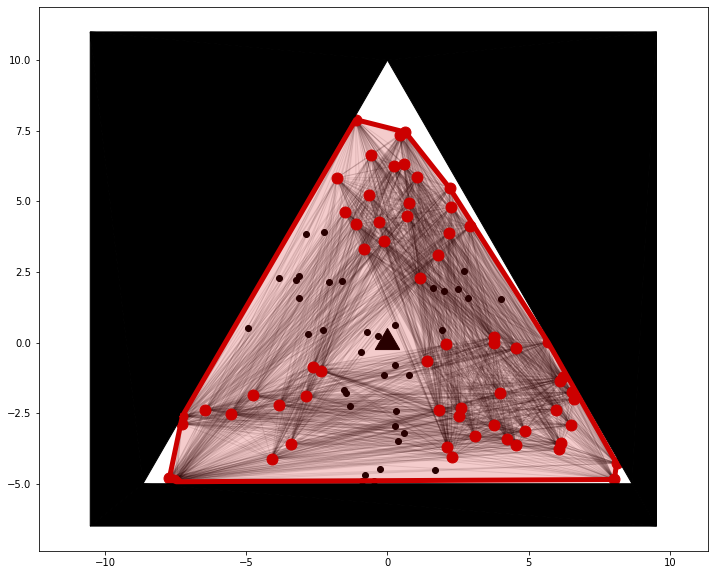

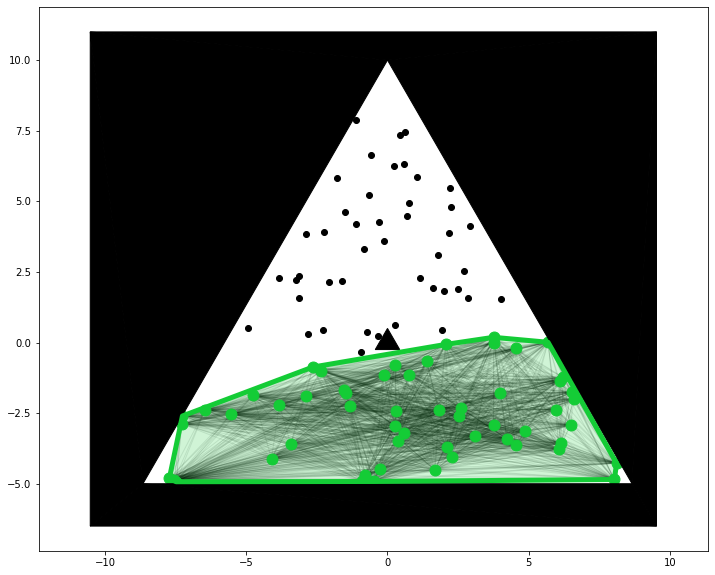

In [19]:
fig, ax = plt.subplots(1,1, figsize = (12,10))
world.plot_cfree(ax)
for i in range(pts.shape[0]-1):
    for j in range(i+1, pts.shape[0]):
        if i in clique_no_hyp and j in clique_no_hyp and ad_mat[i,j] ==1:
            plt.plot(pts[[i,j], 0], pts[[i,j], 1], c = 'k', alpha = 0.1, linewidth = 1, zorder = 0)
ax.scatter(pts[:, 0], pts[:, 1], c = 'k')

seed_polys = seed_poly_hulls([clique_no_hyp], pts)
plot_polys(seed_polys, [clique_no_hyp], pts, ax, [(0.8,0,0)])
ax.axis('equal')
plt.savefig('triangle_max_clique_no_hyp.pdf')
fig, ax = plt.subplots(1,1, figsize = (12,10))
world.plot_cfree(ax)
ax.scatter(pts[:, 0], pts[:, 1], c = 'k')
for i in range(pts.shape[0]-1):
    for j in range(i+1, pts.shape[0]):
        if i in clique_hyp and j in clique_hyp and ad_mat[i,j] ==1:
            plt.plot(pts[[i,j], 0], pts[[i,j], 1], c = 'k', alpha = 0.1, linewidth = 1, zorder = 0)
seed_polys = seed_poly_hulls([clique_hyp], pts)
plot_polys(seed_polys, [clique_hyp], pts, ax, colors)
plt.savefig('triangle_max_clique_hyp.pdf')
ax.axis('equal')
print(len(clique_no_hyp))
print(len(clique_hyp))

In [38]:
idxs2 = idxs[np.where(pts[idxs,0]<=4)[0]]
idxs2

array([ 0,  1, 10, 14, 21, 25, 28, 38, 39, 47, 50, 80, 83, 90, 94])

In [40]:
idxs3 = idxs[np.where(pts[idxs2,0]>=3.7)[0]]
idxs3

array([39])

average time = 8.30 over 10 tries, with 50 points excluded, on a graph of size 400
success
binary assignment:  [-0. -0. -0.  0. -0. -0. -0.  0. -0. -0. -0. -0.  0.  1. -0.  1. -0. -0.
 -0. -0. -0. -0. -0.  1. -0. -0. -0.  1. -0. -0. -0. -0. -0.  0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0.
 -0.  0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0. -0. -0.
 -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0.  0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.  0.  0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. 

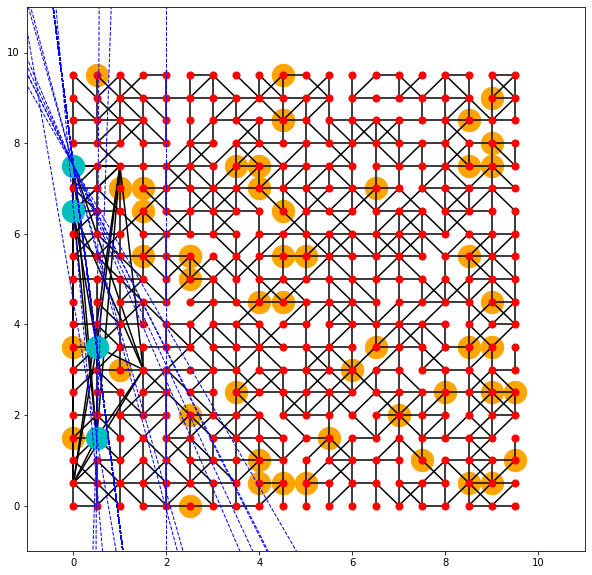

In [243]:
N = 20
sp = 0.5
np.random.seed(0)
points  = []
for i in range(N):
    for j in range(N):
        points.append(np.array([i*sp,j*sp]))
points = np.array(points)
ad_mat = np.zeros((N*N,N*N))
for i in range(N-1):
    for j in range(N-1):
        i1 = i + j*N
        i2 = i+1+ j*N
        i3 = i+1 +(j+1)*N
        i4 = i +(j+1)*N
        edges = np.where(np.random.rand(6)>0.5)[0]
        for e in edges:
            if e==0:
                ad_mat[i1,i2] =1
                ad_mat[i2,i1] =1
            if e==1:
                ad_mat[i2,i3] =1
                ad_mat[i3,i2] =1
            if e==2:
                ad_mat[i3,i4] =1
                ad_mat[i4,i3] =1
            if e==3:
                ad_mat[i4,i1] =1
                ad_mat[i1,i4] =1
            if e==4:
                ad_mat[i1,i3] =1
                ad_mat[i3,i1] =1
            if e==5:
                ad_mat[i2,i4] =1
                ad_mat[i4,i2] =1

# ad_mat[1,-1] = 1
# ad_mat[-1,1] = 1
# ad_mat[1,-2] = 1
# ad_mat[-2,1] = 1
# ad_mat[1,-3] = 1
# ad_mat[-3,1] = 1
# ad_mat[1,-4] = 1
# ad_mat[-4,1] = 1

# ad_mat[2,-1] = 1
# ad_mat[-1,2] = 1
# ad_mat[2,-2] = 1
# ad_mat[-2,2] = 1
# ad_mat[2,-3] = 1
# ad_mat[-3,2] = 1
# ad_mat[2,-4] = 1
# ad_mat[-4,2] = 1
clique = [1, 13, 23, 15, 27, 55, 66]
for i,c in enumerate(clique[:-1]):
    for c2 in clique[i+1:]:
        ad_mat[c,c2] = 1
        ad_mat[c2,c] = 1

fig,ax = plt.subplots(1,1, figsize = (10,10))
ax.scatter(points[:,0], points[:,1], s= 50, c = 'r', zorder = 3)


for i in range(len(points)-1):
    for j in range(i+1, len(points)):
        if ad_mat[i,j]:
            x = [points[i,0], points[j,0]]
            y = [points[i,1], points[j,1]]
            ax.plot(x,y, c = 'k')

#ax = plt.gca()
ax.set_xlim([-1,1+N*sp])
ax.set_ylim([-1,1+N*sp])
#ax.axis('equal')
#excl =99
excl = 50
points_to_exclude =  points[np.random.choice(N**2,excl), :]

import time
tries = 10
t1 = time.time()
for _ in range(tries):
    success, v, lambdas, gammas = max_clique_w_exclusion_points(ad_mat, points, points_to_exclude)
t2 = time.time()
print(f"average time = {(t2-t1)/tries:.2f} over {tries} tries, with {excl} points excluded, on a graph of size {N**2}")

ax.scatter(points_to_exclude[:, 0], points_to_exclude[:,1], c = 'orange', s = 500, zorder =1)
#lambdas = lambdas.squeeze()

print(f"{'success' if success else 'optimzation failed'}")
print('binary assignment: ', v)
print('lambda critical: ', lambdas)
#print('gamma critical: ', gammas)
pts_idx = np.where(np.abs(v)>=1e-4)[0]
clique = np.array([points[i] for i in pts_idx])
ax.scatter(clique[:, 0], clique[:, 1], c = 'c', s = 500, zorder = 10)

for i in range(lambdas.shape[0]):
    lamb = lambdas[i,:]
    hpts = hyperplanepoints(lamb)#np.clip(hyperplanepoints(lamb), -1, (N)*sp)
    ax.plot(hpts[:,0], hpts[:,1], linewidth = 1, linestyle = '--', c= 'b', zorder = 20)

In [239]:
from independent_set_solver import solve_max_independent_set_integer

tries = 10
t1 = time.time()
for _ in range(tries):
    adj_curr = ad_mat.copy()
    adj_curr = 1- adj_curr
    np.fill_diagonal(adj_curr, 0)
    val = solve_max_independent_set_integer(adj_curr)
t2 = time.time()
print(f"average time = {(t2-t1)/tries} over {tries} tries, with {0} points excluded, on a graph of size {N**2}")

average time = 0.09878907203674317 over 10 tries, with 0 points excluded, on a graph of size 100


In [234]:
val

(7.0, (array([ 1, 13, 15, 23, 27, 55, 66]),))

In [99]:
A = np.array([lamb_sol[0], lamb_sol[1]]).reshape(1,2)
b = np.array([lamb_sol[2]])
np.linalg.solve(A.T@A,A.T@b.reshape(1,1))

LinAlgError: Singular matrix

In [98]:
A.T@b.reshape(1,1)

array([[-2.],
       [ 0.]])

In [96]:
A.shape

(2, 1)

In [41]:
np.ones((1,n))@gammas[i,:]

array([<Expression "(x(4,0) + x(4,1) + x(4,2) + x(4,3) + x(4,4))">],
      dtype=object)

In [28]:
np.matmul(Points_mat,lambdas[i,:])

array([<Expression "x(0,2)">, <Expression "(x(0,0) + x(0,2))">,
       <Expression "(x(0,0) + x(0,1) + x(0,2))">,
       <Expression "(x(0,1) + x(0,2))">,
       <Expression "(2 * x(0,0) + 0.5 * x(0,1) + x(0,2))">], dtype=object)